# 2 - LDA Model Implementation Using Abstracts Only

In this notebook, we applied the optimized LDA model—previously fine-tuned and saved from Notebook 1 to the abstracts dataset. The goal of this experiment was to assess how richer textual input influences topic modeling results. The workflow followed the same steps as outlined in Notebook 1, excluding the hyperparameter fine-tuning phase, as the optimized parameters were directly reused.

In [ ]:
# carbon tracker initialization
from codecarbon import OfflineEmissionsTracker
tracker = OfflineEmissionsTracker(country_iso_code="IRL", project_name="LDA", measure_power_secs=60)
tracker.start()

[codecarbon INFO @ 19:10:28] offline tracker init
[codecarbon INFO @ 19:10:28] [setup] RAM Tracking...
[codecarbon INFO @ 19:10:28] [setup] CPU Tracking...
[codecarbon WARNING @ 19:10:28] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 19:10:28] We saw that you have a Apple M2 but we don't know it. Please contact us.
[codecarbon INFO @ 19:10:28] CPU Model on constant consumption mode: Apple M2
[codecarbon INFO @ 19:10:28] [setup] GPU Tracking...
[codecarbon INFO @ 19:10:28] No GPU found.
[codecarbon INFO @ 19:10:28] >>> Tracker's metadata:
[codecarbon INFO @ 19:10:28]   Platform system: macOS-15.4-arm64-arm-64bit
[codecarbon INFO @ 19:10:28]   Python version: 3.9.18
[codecarbon INFO @ 19:10:28]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 19:10:28]   Available RAM : 8.000 GB
[codecarbon INFO @ 19:10:28]   CPU count: 8
[codecarbon INFO @ 19:10:28]   CPU model: Appl

## Intsallations

In [ ]:
# This script is intended to be run in a Jupyter notebook environment
# such as Google Colab or JupyterLab.

# install dependencies
!pip install -r requirements.txt
# clear output
from IPython.display import clear_output
clear_output()

In [ ]:
import re
import string
import gdown
import warnings
from collections import Counter, OrderedDict
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis.gensim
import scipy as sp
import seaborn as sns
from IPython.display import clear_output
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize
from tqdm.notebook import tqdm

import gensim
from gensim import models, corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import gensim.models.phrases as gen

# Suppress warnings
warnings.filterwarnings('ignore')

# Initialize lemmatizer
lmtzr = WordNetLemmatizer()


## Step 1 - Data Loading
Load dataset.

In [ ]:
# download the dataset using gdown
file_id = "1eZpccbF__INfFEYernG2EGPXhhTGOme1"
output_name = "cleaned_dataset.csv"

url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, output_name, quiet=False)

In [ ]:
data = pd.read_csv('cleaned_dataset.csv') # Load the cleaned data
data.head() # Display the first few rows of the dataset

,processed_title,processed_abstract,processed_title_and_abstract
0,population health strategy support hospital in...,country affect number people infect dead first...,population health strategy support hospital in...
1,gis jungle experiential environmental educatio...,travel course build hempel legacy environmenta...,gis jungle experiential environmental educatio...
2,impact american attitude study twitter,past research study social determinant attitud...,impact american attitude study twitter past re...
3,paxlovidtm information guidance member,american society ae official statement provide...,paxlovidtm information guidance member america...
4,upper respiratory tract infection sport immune...,simple summary review clarify relationship hea...,upper respiratory tract infection sport immune...


In [ ]:
# remove null values
data['processed_abstract'] = data['processed_abstract'].fillna('')
data['processed_title'] = data['processed_title'].fillna('')
data['processed_title_and_abstract'] = data['processed_title_and_abstract'].fillna('')

## Step 2 - Creating Vocabulary Bag-of-Words
Using Abstracts

In [4]:
# changed the following from abstracts to texts
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /Users/sophie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import ast

# Convert string representations of lists into actual lists
data['processed_abstract'] = data['processed_abstract'].apply(lambda x: x.split() if isinstance(x, str) and x else [])

# Now create docs
docs = data['processed_abstract'].tolist()


[codecarbon INFO @ 19:12:28] Energy consumed for RAM : 0.000100 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:12:28] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:12:28] 0.001517 kWh of electricity used since the beginning.


In [9]:
 # Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents. Could change to 13%
dictionary.filter_extremes(no_below=20, no_above=0.1) # 10 => 20, 0.2 => 0.1
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initital documents: 124756
Number of unique words after removing rare and common words: 13859


In [10]:
#creating a bag-of-words
len_of_dict = len(dictionary)
corpus = [dictionary.doc2bow(doc) for doc in docs]

bow_doc = corpus[len_of_dict]

print(f"bow_doc: {len(bow_doc)}")


bow_doc: 19


In [11]:
for i in range(len(bow_doc)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc[i][0],
                                                     dictionary[bow_doc[i][0]],
                                                     bow_doc[i][1]))

Word 73 ("collect") appears 1 time.
Word 136 ("difference") appears 1 time.
Word 470 ("demographic") appears 2 time.
Word 485 ("p") appears 2 time.
Word 534 ("statistical") appears 1 time.
Word 584 ("mechanism") appears 3 time.
Word 653 ("mortality") appears 2 time.
Word 950 ("injury") appears 6 time.
Word 1002 ("long") appears 1 time.
Word 1041 ("less") appears 1 time.
Word 1248 ("state") appears 1 time.
Word 1479 ("retrospective") appears 1 time.
Word 2345 ("trauma") appears 4 time.
Word 2520 ("volume") appears 1 time.
Word 3373 ("encounter") appears 2 time.
Word 5162 ("los") appears 1 time.
Word 9050 ("blunt") appears 1 time.
Word 9467 ("penetrate") appears 1 time.
Word 9568 ("burn") appears 1 time.


## Step 3 - Create LDA Model

In [12]:
#creating LDA Model
def get_lda_topics(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10)
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

In [ ]:
# get hyperparameters from finetuned model
lda_model = gensim.models.LdaModel.load('lda_model_final.gensim')
num_topics = lda_model.num_topics
alpha = lda_model.alpha
beta = lda_model.eta
print('Number of topics:', num_topics)
print('Alpha:', alpha)
print('Beta:', beta)

Number of topics: 8
Alpha: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
Beta: [1. 1. 1. ... 1. 1. 1.]


[codecarbon INFO @ 19:13:28] Energy consumed for RAM : 0.000150 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:13:28] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:13:28] 0.002275 kWh of electricity used since the beginning.


In [14]:
# setting the final model, except for the 3 hyperparameters, keeping the rest the same

lda_model_final = gensim.models.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           chunksize=500,
                                           passes=20,
                                           alpha=alpha[0],
                                           eta=beta[0],
                                           per_word_topics=True)
                                           

[codecarbon INFO @ 19:14:28] Energy consumed for RAM : 0.000200 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:14:28] Energy consumed for all CPUs : 0.002834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:14:28] 0.003034 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:15:28] Energy consumed for RAM : 0.000250 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:15:28] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:15:28] 0.003792 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:16:28] Energy consumed for RAM : 0.000300 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:16:28] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:16:28] 0.004550 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:17:28] Energy consumed for RAM : 0.000350 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:17:28] Energy consumed for all CPUs : 0.004959 kWh. Total CPU Power : 42.5 W
[codeca

## Step 4 - Results

In [15]:
#viewing results
topics = get_lda_topics(lda_model_final, num_topics)

In [20]:
print(topics)

   Topic # 01   Topic # 02 Topic # 03  Topic # 04     Topic # 05  Topic # 06  \
0     student      propose  mortality     protein    participant      policy   
1     medical  performance         ci        drug         mental    economic   
2     service         mask    symptom      immune          child      people   
3    practice        image          p      target        anxiety    epidemic   
4      online      network  admission        gene          woman      global   
5  healthcare    technique      death  expression         survey    outbreak   
6   education  application   severity   mechanism  psychological      crisis   
7     program     accuracy      covid    receptor        symptom       paper   
8        face      dataset  pneumonia        bind         stress       world   
9    training          air    therapy        host     depression  government   

     Topic # 07    Topic # 08  
0        cancer       vaccine  
1       surgery   vaccination  
2      surgical      an

[codecarbon INFO @ 19:21:28] Energy consumed for RAM : 0.000550 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:21:28] Energy consumed for all CPUs : 0.007791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:21:28] 0.008341 kWh of electricity used since the beginning.


In [16]:
#enabling visualization
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [17]:
#visualizing using Gensim
vis = pyLDAvis.gensim.prepare(lda_model_final, corpus, dictionary)
pyLDAvis.display(vis)

#optional save
#pyLDAvis.save_html(vis, 'lda.html')

In [ ]:
#saving model and specifying how many top words you want
# lda_model.save('model4.gensim')
topics = lda_model_final.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.011*"student" + 0.008*"medical" + 0.008*"service" + 0.007*"practice" + 0.007*"online" + 0.006*"healthcare" + 0.006*"education" + 0.006*"program" + 0.005*"face" + 0.005*"training"')
(1, '0.008*"propose" + 0.006*"performance" + 0.006*"mask" + 0.005*"image" + 0.005*"network" + 0.004*"technique" + 0.004*"application" + 0.004*"accuracy" + 0.004*"dataset" + 0.004*"air"')
(2, '0.014*"mortality" + 0.012*"ci" + 0.009*"symptom" + 0.009*"p" + 0.007*"admission" + 0.007*"death" + 0.006*"severity" + 0.006*"covid" + 0.005*"pneumonia" + 0.005*"therapy"')
(3, '0.016*"protein" + 0.011*"drug" + 0.007*"immune" + 0.007*"target" + 0.007*"gene" + 0.007*"expression" + 0.006*"mechanism" + 0.006*"receptor" + 0.006*"bind" + 0.005*"host"')
(4, '0.012*"participant" + 0.012*"mental" + 0.012*"child" + 0.010*"anxiety" + 0.009*"woman" + 0.008*"survey" + 0.008*"psychological" + 0.008*"symptom" + 0.008*"stress" + 0.007*"depression"')
(5, '0.007*"policy" + 0.006*"economic" + 0.005*"people" + 0.005*"epidemic" + 0.0

[codecarbon INFO @ 19:22:28] Energy consumed for RAM : 0.000600 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:22:28] Energy consumed for all CPUs : 0.008500 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:22:28] 0.009099 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:23:28] Energy consumed for RAM : 0.000650 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:23:28] Energy consumed for all CPUs : 0.009208 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:23:28] 0.009858 kWh of electricity used since the beginning.


## Step 5 - Evaluation

In [19]:
coherences = ['c_v', 'u_mass', 'c_uci', 'c_npmi']
for coherence in coherences:
    if coherence == 'u_mass':
        cm = CoherenceModel(model=lda_model_final, corpus=corpus, dictionary=dictionary, coherence=coherence)
    else:
        cm = CoherenceModel(model=lda_model_final, texts=docs, dictionary=dictionary, coherence=coherence)
    print(f'Coherence Score {coherence}: {cm.get_coherence()}\n')


[codecarbon INFO @ 19:20:28] Energy consumed for RAM : 0.000500 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:20:28] Energy consumed for all CPUs : 0.007085 kWh. Total CPU Power : 42.5 W


Coherence Score c_v: 0.62571170565556



[codecarbon INFO @ 19:20:29] 0.007585 kWh of electricity used since the beginning.


Coherence Score u_mass: -2.27952057149477

Coherence Score c_uci: 0.5924505348885868

Coherence Score c_npmi: 0.07095921938975189



## Step 6: Save the results

In [22]:
import json

# Create a more structured dictionary to store topic information
topic_data = {
    "model_info": {
        "num_topics": int(num_topics),
        "alpha": float(alpha[0]),
        "beta": float(beta[0]),
        "coherence_score_cv": float(0.62571170565556)
    },
    "topics": {}
}

# Extract the top words for each topic
for i in range(num_topics):
    topic_words = lda_model_final.show_topic(i, topn=10)  # Get top 10 words for each topic
    
    # Store as a list of word-weight pairs to preserve ranking
    topic_data["topics"][f"Topic_{i+1}"] = {
        "top_words": [{"word": word, "weight": float(weight)} for word, weight in topic_words]
    }

# Save to JSON file
with open('lda_abstract_topics.json', 'w') as f:
    json.dump(topic_data, f, indent=4)

print(f"Saved {num_topics} topics with model information to 'lda_abstract_topics.json'")

Saved 8 topics with model information to 'lda_abstract_topics.json'


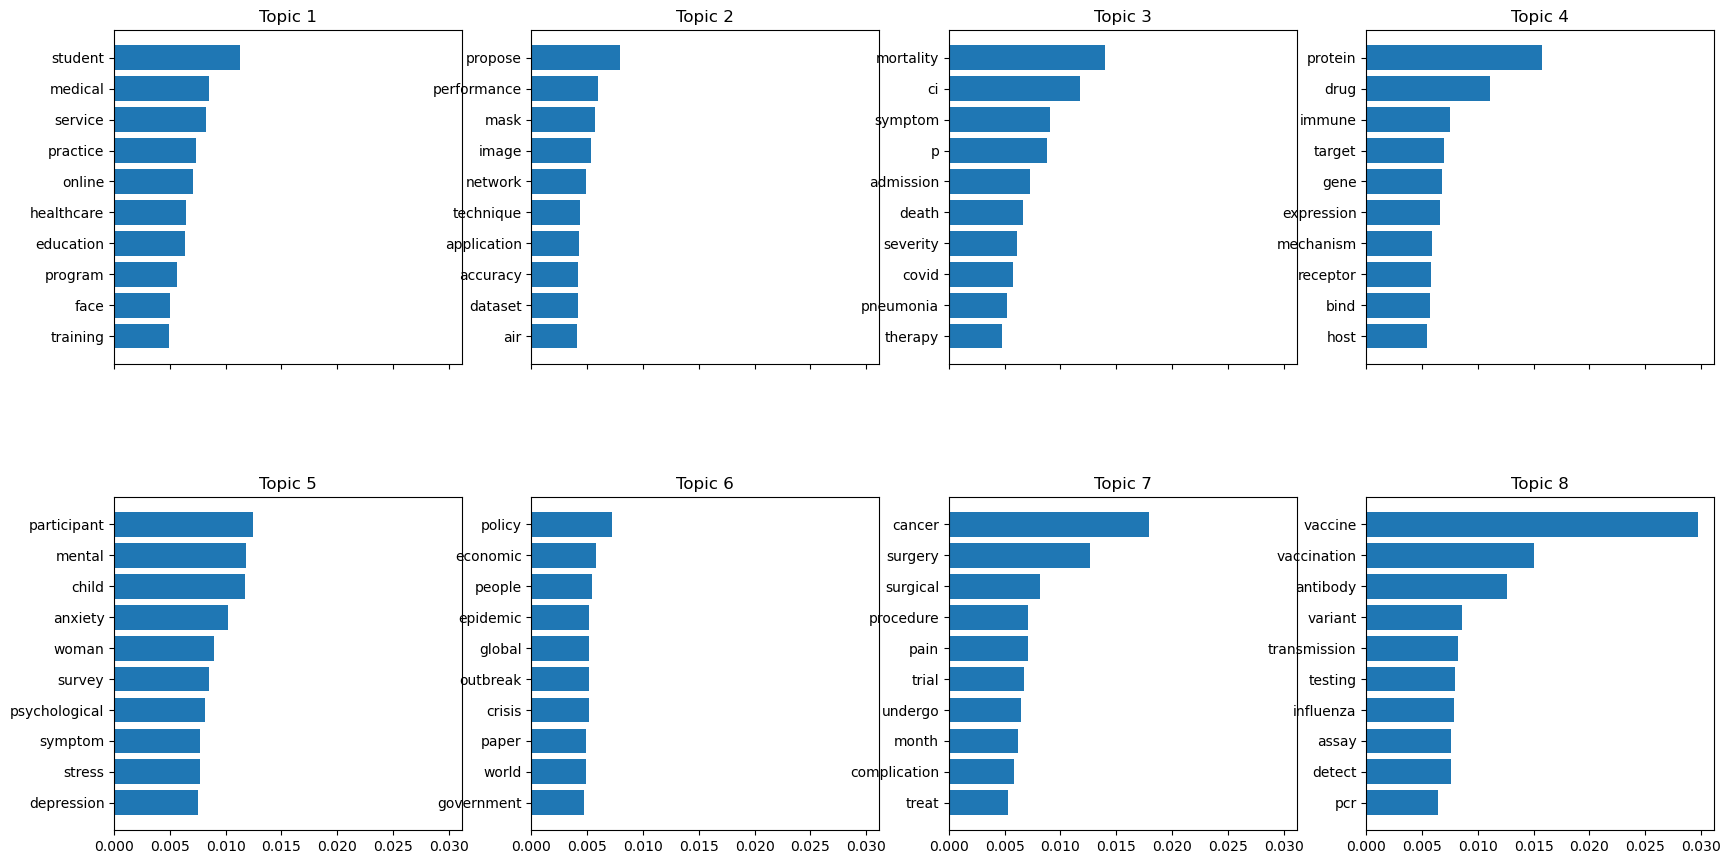

In [23]:
# Plotting the top words in each topic
def plot_top_words_gensim(model, feature_names, n_top_words):
    # Dynamically calculate the grid size based on the number of topics
    n_rows = (num_topics + 3) // 4  # 4 topics per row
    fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5 * n_rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.show_topics(formatted=False, num_topics=num_topics, num_words=n_top_words)):
        topic_words = topic[1]
        if topic_idx < len(axes):  # Ensure we don't access out-of-bounds axes
            ax = axes[topic_idx]
        # Extract top features (words) and their weights
        top_features = [word for word, weight in topic_words]
        weights = [weight for word, weight in topic_words]
        
        ax.barh(top_features, weights, align='center')
        ax.set_title(f'Topic {topic_idx + 1}')
        ax.invert_yaxis()
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4)
    plt.show()

# Get the feature names from the dictionary
feature_names = dictionary.values()
# Plot the top words in each topic
plot_top_words_gensim(lda_model_final, feature_names, n_top_words=10)

In [24]:
tracker.stop()

[codecarbon INFO @ 19:24:20] Energy consumed for RAM : 0.000693 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 19:24:20] Energy consumed for all CPUs : 0.009816 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:24:20] 0.010509 kWh of electricity used since the beginning.


0.003056080166303693